# **Data import & import**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI hackathon/data/')

In [6]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

train_features =pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_features.csv')
submission = pd.read_csv('sample_submission.csv')

# **Data Observation**
index 26 : Non-Exercise 

id, 600

train data 3125

test data 782



In [6]:
train_features

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [7]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train_features['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [8]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


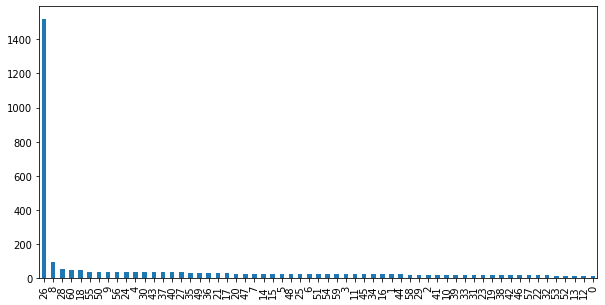

In [9]:
# 26번 데이터는 Non-Exercise data로 train 데이터의 절반 이상을 차지하고 있다
plt.figure(figsize=(10,5))
train_labels['label'].value_counts().plot(kind='bar')

# **Data Preprocessing**
data split, data scaling ... 

*  X_train_acc, X_train_gy 
*  X_test_acc, X_test_gy



In [7]:
# 데이터 분할
act_list = train_features.iloc[:,2:].columns
acc_list = ['acc_x','acc_y','acc_z']
gy_list = ['gy_x','gy_y','gy_z']
act_list

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [8]:
# Scaling
# sklearn 의 data preprocessing - sklearn에서 제공하는 기본 스케일러 중 하나 
scaler = StandardScaler()
train_features[act_list] = scaler.fit_transform(train_features[act_list])
test[act_list] = scaler.transform(test[act_list])
train_features

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831


In [9]:
# acceleromete, gyroscope sensor feature split
def sensor_split(data):
  X_acc = []
  X_gy = []

  for i in tqdm(data['id'].unique()):
      temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])
      temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])
      X_acc.append(temp_acc)
      X_gy.append(temp_gy)
      
  X_acc = np.array(X_acc).reshape(-1,600,3)
  X_gy = np.array(X_gy).reshape(-1,600,3)

  return X_acc, X_gy

In [10]:
X_train_acc, X_train_gy = sensor_split(train_features)

X_test_acc, X_test_gy = sensor_split(test)

100%|██████████| 782/782 [00:03<00:00, 215.36it/s]


# **Data Augmentation**

time warping, permutation...

In [11]:
# 데이터 증강

# Time Warping
sigma = 0.2
knot = 4

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

# Permutation
def Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return (X_new)

# Rotation
def Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

# Jittering
def Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

# Magnitude Warping
def MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

In [12]:
def ts_aug(data, method,sigma):
  new_data=[]
  for i in range(data.shape[0]):
    temp=list(method(data[i], sigma))
    new_data.append(temp)
  return np.array(new_data)

In [13]:
X_train_acc_comb = Permutation(Jitter(X_train_acc))
X_train_acc_perm = Permutation(X_train_acc)
X_train_acc_timew = ts_aug(X_train_acc, TimeWarp, 0.2)
X_train_acc_magw = ts_aug(X_train_acc, MagWarp, 0.2)

X_train_gy_comb = Permutation(Jitter(X_train_gy))
X_train_gy_perm = Permutation(X_train_gy)
X_train_gy_timew = ts_aug(X_train_gy, TimeWarp, 0.2)
X_train_gy_magw = ts_aug(X_train_gy, MagWarp, 0.2)

In [14]:
X_train_acc = np.append(X_train_acc, X_train_acc_comb, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_perm, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_timew, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_magw, axis=0)

X_train_gy = np.append(X_train_gy, X_train_gy_comb, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_perm, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_timew, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_magw, axis=0)

In [15]:
acc = [e for sl in X_train_acc for e in sl]

df_report = np.stack(acc, axis = 0)
df_acc = pd.DataFrame(df_report, columns= ['acc_x', 'acc_y', 'acc_z'])

df_acc

,acc_x,acc_y,acc_z
0,2.307314,-0.029939,-0.432104
1,2.421086,-0.063321,-0.504058
2,2.444664,-0.056749,-0.654199
3,2.428612,-0.116782,-0.573407
4,2.439475,-0.044220,-0.588886
...,...,...,...
9374995,-0.353975,-0.626500,0.657763
9374996,-0.314167,-0.637264,0.764158
9374997,-0.289413,-0.658770,0.871042
9374998,-0.243389,-0.691200,0.907916


In [16]:
# gy

gy = [e for sl in X_train_gy for e in sl]

df_report = np.stack(gy, axis = 0)
df_gy = pd.DataFrame(df_report, columns= ['gy_x', 'gy_y', 'gy_z'])

df_gy

,gy_x,gy_y,gy_z
0,0.011776,-0.410859,-0.461007
1,0.026484,-0.528052,-0.365459
2,-0.037962,-0.596041,-0.366767
3,0.066099,-0.725311,-0.401232
4,0.091969,-0.784094,-0.408413
...,...,...,...
9374995,-0.555997,-1.299599,-1.420589
9374996,-0.579694,-1.270957,-1.425509
9374997,-0.541647,-1.232334,-1.474558
9374998,-0.461847,-1.236195,-1.489573


In [17]:
# acc, gy 데이터프레임 병합

df_aug_result = pd.concat([df_acc, df_gy], axis = 1)
df_aug_result.insert(0, 'id', 0)
df_aug_result.insert(1, 'time', 1)
df_aug_result

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,1,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,1,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,1,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.353975,-0.626500,0.657763,-0.555997,-1.299599,-1.420589
9374996,0,1,-0.314167,-0.637264,0.764158,-0.579694,-1.270957,-1.425509
9374997,0,1,-0.289413,-0.658770,0.871042,-0.541647,-1.232334,-1.474558
9374998,0,1,-0.243389,-0.691200,0.907916,-0.461847,-1.236195,-1.489573


In [18]:
df_aug_result.loc[600*0:600*0+600, 'time']

0      1
1      1
2      1
3      1
4      1
      ..
596    1
597    1
598    1
599    1
600    1
Name: time, Length: 601, dtype: int64

In [19]:
train = df_aug_result
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,1,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,1,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,1,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.353975,-0.626500,0.657763,-0.555997,-1.299599,-1.420589
9374996,0,1,-0.314167,-0.637264,0.764158,-0.579694,-1.270957,-1.425509
9374997,0,1,-0.289413,-0.658770,0.871042,-0.541647,-1.232334,-1.474558
9374998,0,1,-0.243389,-0.691200,0.907916,-0.461847,-1.236195,-1.489573


In [20]:
n = 4
train_labels_copy = train_labels.copy()
for i in range(0, n):
    train_labels = train_labels.append(train_labels_copy, ignore_index=True)
train_labels = train_labels.reset_index()
train_labels

,index,id,label,label_desc
0,0,0,37,Shoulder Press (dumbbell)
1,1,1,26,Non-Exercise
2,2,2,3,Biceps Curl (band)
3,3,3,26,Non-Exercise
4,4,4,26,Non-Exercise
...,...,...,...,...
15620,15620,3120,26,Non-Exercise
15621,15621,3121,26,Non-Exercise
15622,15622,3122,15,Dynamic Stretch (at your own pace)
15623,15623,3123,26,Non-Exercise


# **속도, 각속도 추가**

In [26]:
# 속도, 각속도 추가
feature_names = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']

grad_cols=[]
for col in feature_names:
    grad_cols.append(f"grad_{col}")

integ_cols = []
for col in feature_names:
    integ_cols.append(f"integ_{col}")
    
total_feature_names = feature_names + grad_cols + integ_cols

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    train.loc[train['id']==uid, grad_cols] = grad
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    test.loc[test['id']==uid, grad_cols] = grad
    
print(train.shape, test.shape)
train.head()

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    train.loc[train['id']==uid, integ_cols] = integ
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    test.loc[test['id']==uid, integ_cols] = integ
    
print(train.shape, test.shape)
train

 12%|█▏        | 837/6707 [06:27<45:20,  2.16it/s]


KeyboardInterrupt: ignored

In [28]:
# 가속도 feature 추가
train['acc_t']  = train.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)
test['acc_t']  = test.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)

display(train)
display(test)

KeyboardInterrupt: ignored

In [22]:
#0~599까지 숫자를 담은 리스트 생성(for문 실행 속도 줄이기 위해)
list600 = [n for n in range(600)]

for i in range(int(len(df_aug_result)/600)):
  df_aug_result.loc[600*i:600*i+599, 'id'] = i              # id값 설정
  df_aug_result.loc[600*i:600*i+599, 'time'] = list600      # 리스트값 time열에 붙여넣기
  #print(i, end=' ')

##여기까지 np->df 변환하는 부분

KeyboardInterrupt: ignored

# **모델링**

In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import StratifiedKFold

In [43]:
X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])
X.shape

TensorShape([15625, 600, 6])

In [52]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,1,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,1,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,1,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.353975,-0.626500,0.657763,-0.555997,-1.299599,-1.420589
9374996,0,1,-0.314167,-0.637264,0.764158,-0.579694,-1.270957,-1.425509
9374997,0,1,-0.289413,-0.658770,0.871042,-0.541647,-1.232334,-1.474558
9374998,0,1,-0.243389,-0.691200,0.907916,-0.461847,-1.236195,-1.489573


In [41]:
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(15625, 61)

In [46]:
train_labels

,index,id,label,label_desc
0,0,0,37,Shoulder Press (dumbbell)
1,1,1,26,Non-Exercise
2,2,2,3,Biceps Curl (band)
3,3,3,26,Non-Exercise
4,4,4,26,Non-Exercise
...,...,...,...,...
15620,15620,3120,26,Non-Exercise
15621,15621,3121,26,Non-Exercise
15622,15622,3122,15,Dynamic Stretch (at your own pace)
15623,15623,3123,26,Non-Exercise


In [61]:
tf.cast(X, tf.int64)

<tf.Tensor: shape=(15625, 600, 6), dtype=int64, numpy=
array([[[ 2,  0,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0,  0],
        ...,
        [ 2,  0,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0,  0],
        [ 2,  0, -1,  0,  0,  0]],

       [[ 0,  0,  1,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  0],
        ...,
        [ 0,  0,  1,  1,  0,  0],
        [ 0,  0,  1,  1,  0,  0],
        [ 0,  0,  1,  1,  0,  0]],

       [[ 0,  0,  1,  0, -2,  0],
        [ 0,  0,  1,  0, -2,  0],
        [ 1,  0,  1,  0, -2,  0],
        ...,
        [ 0,  0,  2,  0,  1,  0],
        [ 0,  0,  1,  0,  1,  0],
        [ 0,  0,  1,  0,  1,  0]],

       ...,

       [[-1,  0,  0, -3, -2,  2],
        [ 0,  0,  0, -3, -2,  2],
        [ 0,  0,  0, -3, -2,  2],
        ...,
        [-3,  0,  0,  1,  4, -2],
        [-2,  0,  0,  2,  4, -2],
        [-2,  0,  0,  2,  4, -2]],

       [[ 0,  1, -1, -1,  2, -1],
        [ 0,  1, -1, -

In [27]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(600,7)))
model.add(Dense(128, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
skfold = StratifiedKFold(n_splits=3)
idx_iter = 0 
skf_accuracy=[]

for train_idx, test_idx in skfold.split(X, train_labels['label']) :
  idx_iter += 1 
  print(train_idx)
  X_train, X_test = X[train_idx], test[test_idx]
  Y_train, Y_test = train_labels[train_idx], train_labels[test_idx]

  model.fit(X_train, Y_train, epochs=1000, batch_size=2048, validation_split=0.2)
  pred = model.predict(X_test)

  # 반복 시 마다 정확도 측정 
  idx_iter += 1 
  skf_accuracy = np.round(accuracy_score(Y_test, pred), 4)
  train_size = X_train.shape[0]
  test_tize = X_test.shape[0]

  print("\n#{0} 교차 검증 정확도 :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}" .format(idx_iter, accuracy, train_size, test_size))
  print('#{0} 검증 세트 인덱스:{1}'.format(idx_iter, test_index))
  skf_accuracy.append(accuracy)


[ 4365  4659  4687 ... 15622 15623 15624]


TypeError: ignored

In [29]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 7])
test_X.shape

InvalidArgumentError: ignored

In [ ]:
# #k-fold 교차검증
skf = KFold(n_splits=5, shuffle=True)

accuracy = []

for train, validation in skf.split(X, Y):
   model = Sequential()
   model.add(Embedding(vocab_size, 100))
   model.add(LSTM(128))    #model.add(Bidirectional(LSTM(128)))
   model.add(Dense(1, activation='sigmoid'))

   model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

#   # 학습 데이터를 이용해서 학습
   history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)
   model.fit(X[train], Y[train], epochs=100, batch_size=5)


In [ ]:
prediction=model.predict(test_X)
prediction

In [ ]:
prediction.shape

In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

In [ ]:
submission.to_csv('baseline_aug_1.csv', index=False)